In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install geopandas

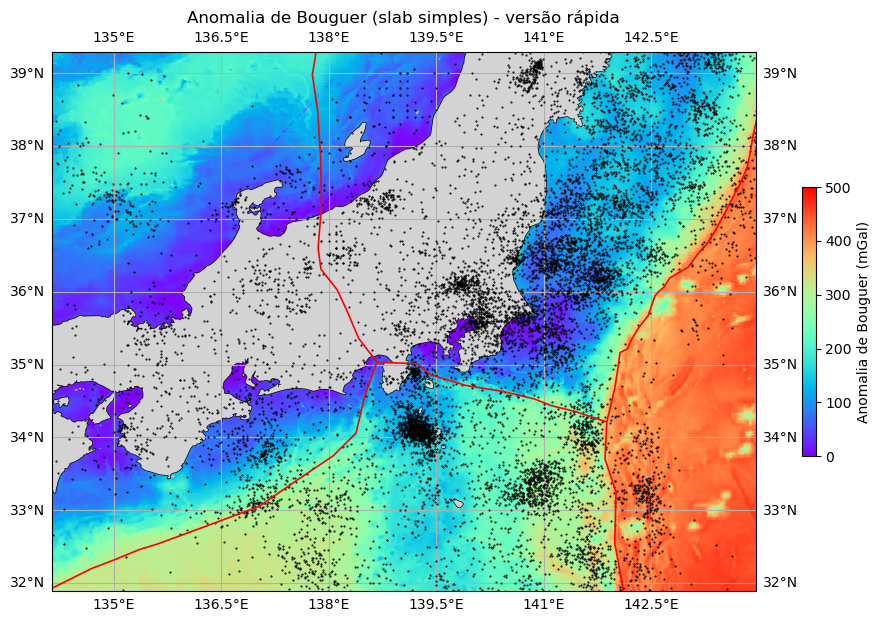

In [3]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

# ----------------- Caminhos -----------------
caminho_netcdf  = r"data-29-09/grav_32.1.nc"   # Free-air (mGal)
caminho_geotiff = r"data-22-09/batimetria.tiff"             # Topo/batim. (m)


# Área de interesse
longitude_min, longitude_max = 134.13, 143.97
latitude_min,  latitude_max  =   31.88,   39.30


# ----------- Escala da figura (mGal) --------
valor_min, valor_max = 0, 500

# --------- Densidades e constantes ----------
rho_crosta = 2.80   # g/cm³
rho_agua   = 1.03   # g/cm³
delta_rho  = (rho_crosta - rho_agua) * 1000.0  # kg/m³
G          = 6.67430e-11                        # SI
FATOR_MGAL = 1e-5                               # 1 mGal = 1e-5 m/s²

# ===== 1) NetCDF: recorte (free-air) =====
ds = xr.open_dataset(caminho_netcdf)
recorte = ds.sel(lon=slice(longitude_min, longitude_max),
                 lat=slice(latitude_min,  latitude_max))
lons = recorte.lon.values
lats = recorte.lat.values
FA   = recorte.z  # mGal

# ===== 2) GEBCO: abrir, garantir WGS84, recortar e reamostrar =====
gebco = rxr.open_rasterio(caminho_geotiff).squeeze(drop=True)  # (y,x)
if not gebco.rio.crs.is_geographic:
    gebco = gebco.rio.reproject("EPSG:4326")
gebco = gebco.rename({"x": "lon", "y": "lat"}).sortby(["lat", "lon"])
gebco = gebco.sel(lon=slice(longitude_min, longitude_max),
                  lat=slice(latitude_min,  latitude_max))
H = gebco.interp(lon=("lon", lons), lat=("lat", lats), method="linear")  # metros

# ===== 3) Bouguer simples: Δg_B = FreeAir - 2πG Δρ H  (mGal) =====
correcao_bouguer_mps2 = 2.0 * np.pi * G * delta_rho * H
correcao_bouguer_mgal = correcao_bouguer_mps2 / FATOR_MGAL
bouguer = FA - correcao_bouguer_mgal  # DataArray (lat, lon), mGal

# ===== 4) Plot no padrão GEOTIFF + LAND cinza =====
fig = plt.figure(figsize=(12, 7))
ax  = plt.axes(projection=ccrs.PlateCarree())
extensao = [lons.min(), lons.max(), lats.min(), lats.max()]
ax.set_extent(extensao, crs=ccrs.PlateCarree())

img = ax.imshow(
    bouguer.values,
    origin='lower',
    extent=extensao,
    transform=ccrs.PlateCarree(),
    cmap='rainbow',
    vmin=valor_min, vmax=valor_max,
    interpolation='nearest',
    zorder=1
)

# Continente em cinza (MÁSCARA VISUAL)
ax.add_feature(cfeature.LAND, facecolor="lightgrey", zorder=2)
ax.coastlines(resolution='10m')

# Grid com rótulos
gl = ax.gridlines(draw_labels=True)

lat_sismos, lon_sismos = np.loadtxt('data-22-09/loc_sismos.txt', usecols=(0,1), unpack=True)
plt.plot(lon_sismos, lat_sismos, 'ko', markersize=0.5)

caminho_shapefile = "data-22-09/PB2002_boundaries.shp"
placas = gpd.read_file(caminho_shapefile)
placas.plot(ax=ax, color='red', linewidth=1.2, transform=ccrs.PlateCarree())

# Colorbar
cbar = plt.colorbar(img, shrink=0.5)
cbar.set_label('Anomalia de Bouguer (mGal)')

plt.title('Anomalia de Bouguer (slab simples) - versão rápida')
plt.savefig('anbouguer.jpeg', dpi=300, bbox_inches='tight')
plt.show()



In [4]:
# ====== CONVERTER PARA XYZ ======

lon2d, lat2d = np.meshgrid(lons, lats)
dados_xyz = np.column_stack([lon2d.ravel(), lat2d.ravel(), bouguer.values.ravel()])
np.savetxt(r"data-29-09/bouguer_fast_xyz.txt",
           dados_xyz, fmt="%.6f %.6f %.6f")



In [5]:
import pandas as pd

prévia = pd.read_csv(
    r"data-29-09/bouguer_fast_xyz.txt",
    delim_whitespace=True,
    header=None,
    names=["lon", "lat", "bouguer_mgal"],
    nrows=20
)

prévia


/tmp/ipykernel_16805/2474460110.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prévia = pd.read_csv(


,lon,lat,bouguer_mgal
0,134.141667,31.891667,314.001252
1,134.158333,31.891667,313.985423
2,134.175000,31.891667,314.085856
3,134.191667,31.891667,314.553185
4,134.208333,31.891667,314.805541
5,134.225000,31.891667,315.121181
6,134.241667,31.891667,315.639308
7,134.258333,31.891667,316.358195
8,134.275000,31.891667,317.539363
9,134.291667,31.891667,319.207595
